In [530]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import *
import math as math 
from numpy.linalg import norm
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [531]:
#Train
train = pd.read_csv('train.csv', delimiter=',', index_col='datetime', parse_dates=True)

train['year'] = train.index.year
train['month'] = train.index.month
train['hour'] = train.index.hour
train['day'] = train.index.weekday
train['calendar_day'] = train.index.day

season = train['month']
season = season.apply(lambda s: 4 if int(s) == 1 or int(s) == 2 else (int(s) - 3) // 3 + 1)   
train = train.drop('season', axis = 1)
train.insert(5, 'season', season)

# weather = train['weather']
# temp = train['temp']
# # humidity = train['humidity']
# bad_conditions = np.arange(weather.shape[0])
# bad_conditions = [5 if temp[i] < 10 else 0 for i in range(weather.shape[0])]
# train['bad_conditions0'] = bad_conditions
# bad_conditions = [15 if temp[i] >= 10 and temp[i] < 22 else 0 for i in range(weather.shape[0])]
# train['bad_conditions10'] = bad_conditions
# bad_conditions = [20 if temp[i] >= 22 and temp[i] < 30 else 0 for i in range(weather.shape[0])]
# train['bad_conditions22'] = bad_conditions
# bad_conditions = [15 if temp[i] >= 30 and temp[i] < 40 else 0 for i in range(weather.shape[0])]
# train['bad_conditions30'] = bad_conditions
# bad_conditions = [1 if temp[i] >= 40 else 0 for i in range(weather.shape[0])]
# train['bad_conditions40'] = bad_conditions

train.head(5)

,holiday,workingday,weather,temp,atemp,season,humidity,windspeed,casual,registered,count,year,month,hour,day,calendar_day
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,9.84,14.395,4,81,0.0,3,13,16,2011,1,0,5,1
2011-01-01 01:00:00,0,0,1,9.02,13.635,4,80,0.0,8,32,40,2011,1,1,5,1
2011-01-01 02:00:00,0,0,1,9.02,13.635,4,80,0.0,5,27,32,2011,1,2,5,1
2011-01-01 03:00:00,0,0,1,9.84,14.395,4,75,0.0,3,10,13,2011,1,3,5,1
2011-01-01 04:00:00,0,0,1,9.84,14.395,4,75,0.0,0,1,1,2011,1,4,5,1


In [532]:
#Test
test = pd.read_csv('test.csv', delimiter=',', index_col='datetime', parse_dates=True)

test['year'] = test.index.year
test['month'] = test.index.month
test['hour'] = test.index.hour
test['day'] = test.index.weekday
test['calendar_day'] = test.index.day

season = test['month']
season = season.apply(lambda s: 4 if int(s) == 1 or int(s) == 2 else (int(s) - 3) // 3 + 1)   
test = test.drop('season', axis = 1)
test.insert(5, 'season', season)

# weather = test['weather']
# temp = test['temp']
# # humidity = test['humidity']
# bad_conditions = np.arange(weather.shape[0])
# bad_conditions = [5 if temp[i] < 10 else 0 for i in range(weather.shape[0])]
# test['bad_conditions0'] = bad_conditions
# bad_conditions = [15 if temp[i] >= 10 and temp[i] < 22 else 0 for i in range(weather.shape[0])]
# test['bad_conditions10'] = bad_conditions
# bad_conditions = [20 if temp[i] >= 22 and temp[i] < 30 else 0 for i in range(weather.shape[0])]
# test['bad_conditions22'] = bad_conditions
# bad_conditions = [15 if temp[i] >= 30 and temp[i] < 40 else 0 for i in range(weather.shape[0])]
# test['bad_conditions30'] = bad_conditions
# bad_conditions = [1 if temp[i] >= 40 else 0 for i in range(weather.shape[0])]
# test['bad_conditions40'] = bad_conditions


In [533]:
# ONE_hot_encoding 
#for hours
hour_hot = pd.get_dummies(train['hour'], prefix='hour_hot')
train = train.join(hour_hot)
hour_hot_test = pd.get_dummies(test['hour'], prefix='hour_hot')
test = test.join(hour_hot_test)
#for weather
weather_hot = pd.get_dummies(train['weather'], prefix='weather_hot')
train = train.join(weather_hot)
weather_hot_test = pd.get_dummies(test['weather'], prefix='weather_hot')
test = test.join(weather_hot_test)
#for season
season_hot = pd.get_dummies(train['season'], prefix='season_hot')
train = train.join(season_hot)
season_hot_test = pd.get_dummies(test['season'], prefix='season_hot')
test = test.join(season_hot_test)

In [534]:
train['hour2'] = (train['hour'])*2
test['hour2'] = (test['hour'])*2

train['dif1'] = (train['windspeed'] - train['atemp'])**2
test['dif1'] = (test['windspeed'] - test['atemp'])**2

train['norm_hum'] = (train['humidity'] / train['humidity'].mean())**2
test['norm_hum'] = (test['humidity'] / test['humidity'].mean())**2

# train['norm_hum2'] = ((train['humidity'] + train['dif1'] + train['hour'])/ 100)**2
# test['norm_hum2'] = ((test['humidity'] + test['dif1'] + test['hour'])/ 100)**2

# train['hum2'] = (train['humidity'] - train['dif1'])**2
# test['hum2'] = (test['humidity'] - test['dif1'])**2

# train['temp2'] = (train['atemp'] - train['temp'])**2
# test['temp2'] = (test['atemp'] - test['temp'])**2

X = train.drop(['casual', 'registered', 'count'], axis = 1)
X_test = test

In [535]:
maxDepth = 3
nEstimators = 1200
subSample = 0.9

y = np.log(train['count'] + 1)
xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample, nthread = 10).fit(X,y)
predictions = np.exp(xgb_model.predict(X)) - 1

predictions = np.round(predictions)

y = train['count']
print(min(abs(predictions - y)))
print(math.sqrt(1 / len(y) * sum((np.log(predictions + 1) - np.log(y + 1))**2)))
print(max(abs(predictions - y)))
print(len([elem for elem in (abs(predictions - y) / y) if elem < 0.1]), train.shape[0])

0.0
0.2243499280330508
367.0
5146 10886


In [536]:
y = np.log(train['count'] + 1)
xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample, nthread = 8).fit(X,y)
predictions = np.exp(xgb_model.predict(X_test)) - 1

predictions = np.round(predictions)
predictions = [0 if predictions[i] < 0.01 else predictions[i] for i in range(predictions.shape[0])]

test.insert(len(test.columns), 'count', predictions)
test.head(5)

,holiday,workingday,weather,temp,atemp,season,humidity,windspeed,year,month,...,weather_hot_3,weather_hot_4,season_hot_1,season_hot_2,season_hot_3,season_hot_4,hour2,dif1,norm_hum,count
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,1,10.66,11.365,4,56,26.0027,2011,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0,214.262261,0.762638,10.0
2011-01-20 01:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,...,0.0,0.0,0.0,0.0,0.0,1.0,2,185.913225,0.762638,4.0
2011-01-20 02:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,...,0.0,0.0,0.0,0.0,0.0,1.0,4,185.913225,0.762638,3.0
2011-01-20 03:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,...,0.0,0.0,0.0,0.0,0.0,1.0,6,3.529138,0.762638,2.0
2011-01-20 04:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,...,0.0,0.0,0.0,0.0,0.0,1.0,8,3.529138,0.762638,1.0


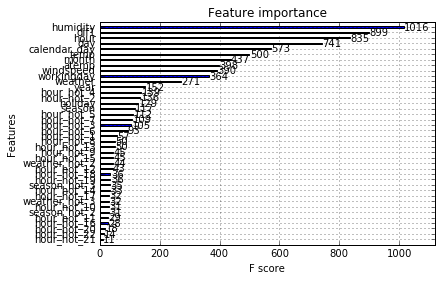

In [537]:
xgb.plot_importance(xgb_model)

In [538]:
newny = pd.DataFrame(test.index)
newny.insert(1, 'count', predictions)
newny.head(20)

newny.to_csv('submission.csv', sep=',', header = True, index = False)

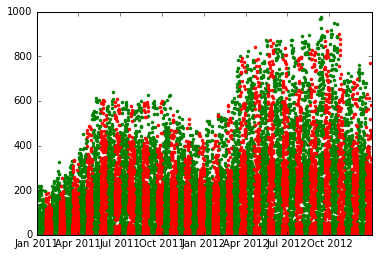

In [539]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

x1 = train.index
x2 = test.index

y1 = train['count']
y2 = test['count']

plt.plot(x1, y1, 'g.', x2, y2, 'r.')
plt.show()

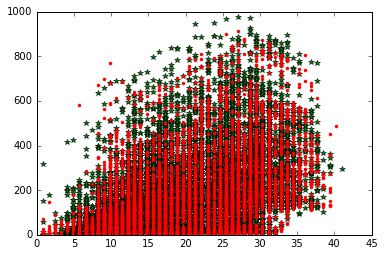

In [540]:
# x1 = train.index
# x2 = test.index

x1 = train['temp']
x2 = test['temp']

y1 = train['count']
y2 = test['count']

plt.plot(x1, y1, 'g*', x2, y2, 'r.')
plt.show()

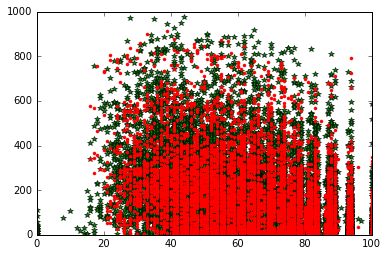

In [541]:
x1 = train['humidity']
x2 = test['humidity']

y1 = train['count']
y2 = test['count']

plt.plot(x1, y1, 'g*', x2, y2, 'r.')
plt.show()

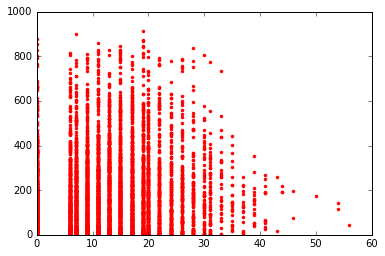

In [542]:
# x2 = test.index
x2 = test['windspeed']
y2 = test['count']

plt.plot(x2, y2, 'r.')
plt.show()

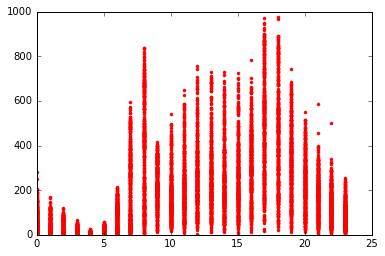

In [543]:
x2 = train['hour']
y2 = train['count']

plt.plot(x2, y2, 'r.')
plt.show()